# Python機械学習 勉強会 第六回「教師あり学習5」

参考文献：  
Pythonではじめる機械学習　2章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

演習データセット：  
https://www.kaggle.com/c/titanic

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split
import seaborn as sns

<br>

---

## はじめに

今回は以下の内容を取り組む

* 勾配ブースティング決定木(GBDT)
    * 概要
    * 実装
* 演習(別資料)

<br>

---

## Ex1. 勾配ブースティング決定木(GBDT)
### Ex1-1. 概要

勾配ブースティング決定木(Gradient Boosting Decision Trees: GBDT)は、  
古典機械学習アルゴリズム(≠ディープラーニング)の中でも、最も強力なアルゴリズムの1つ。

しかし、勉強会に用いている参考書「Pythonではじめる機械学習」では取り扱いが少なかったので、  
改めて勾配ブースティング決定木に関して学んでいく。

<br>

勾配ブースティング決定木とは、ざっくり言えば**決定木アンサンブル学習**の1種。  
* アンサンブルとは、複数のモデルを組み合わせて1つのより強力なモデルを作る手法

<br>

アンサンブル学習には大きく以下2つの手法がある。

* **バギング**：それぞれのモデルを並列で学習し出力
    * 例：ランダムフォレスト  


* **ブースティング**：それぞれのモデルを直列に学習し出力
    * 例：勾配ブースティング決定木

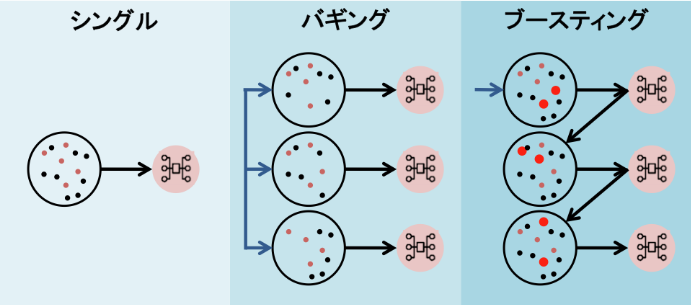

In [2]:
from IPython.display import Image, display_png
display_png(Image('./image/boosting.png'))

<br>

ブースティングでは、前のモデルでの誤差を修正するように学習する。  
つまり、前のモデルで間違えたデータに対して、パラメータを変えて間違えないように修正する。

これらを数十～数百～数千と繰り返すことで、単一のモデルよりも精度を向上させることができる。

<br>

理論の数学的背景などはここでは取り扱わないので、興味あれば下記資料を参照。  
https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf

<br>

### Ex1-2. 実装

勾配ブースティング決定木には様々なパッケージで実装されているが、代表例を示す。

* XGboost : (2016) by Distributed (Deep) Machine Learning Community: DMLC
* LightGBM : (2017) by microsoft
* CatBoost : (2018) by Yandex

それぞれアルゴリズムが異なるため、一概に比較できないが、  
一般的には、XGboost < LightGBM < CatBoost の順で高速で推論できる。  

2019年11月時点では、LightGBMが扱いやすく多数利用されているので、  
本勉強会においてもLightGBMについて学んでいく。

<br>

#### Ex1-2-1. LightGBMの長所と短所(その他GBDTと比較)

**長所**
* 高速に学習できる
* そこそこ高速に推論できる
* 実例が豊富(Kaggleなど)なので、先人の実装例を参考にしやすい
    * 同じく情報が豊富なので調べやすい
    
**短所**
* 過学習しやすい
* デフォルトパラメータが使い物にならない場合が多い
* カテゴリカル変数(離散値)が多いと処理が遅い

詳しくは、下記論文を参照。  
https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf#search='lightGBM+paper

<br>

#### Ex1-2-2. LightGBMの実装例

canserデータセットで実装例を示す。

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

<br>

詳細な実装方法は、LightGBMの公式サイトを参照。  
https://lightgbm.readthedocs.io/en/latest/index.html

In [4]:
# LightGBM
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [5]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
type(cancer.feature_names)

numpy.ndarray

In [7]:
X_train.shape

(426, 30)

In [8]:
# LightGBM
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train, feature_name=list(cancer.feature_names))
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
# まずは。ほぼデフォルトパラメータでやる
lgbm_params = {
    'objective': 'binary', # 二値分類問題
    'metric': 'auc', # 評価指標「AUC」の最大化を目指す
    'verbose': -1, # 学習中の情報を表示しない。表示したい場合は1を指定。
    'random_state': 42 # 乱数シード
}

# 上記のパラメータでモデルを学習する
lgbm = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, verbose_eval=False)

In [9]:
# テストデータを予測する
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

# AUC (Area Under the Curve) を計算する
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred_r = np.where(y_pred > 0.5, 1, 0)

print("light-gbm auc score: {:.3f}".format(auc))
print("light-gbm accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_r)))

light-gbm auc score: 0.998
light-gbm accuracy score: 0.972


<br>

ここでは評価指標として***auc***という指標を用いている。  
詳細な説明は省くが、クラス分類器の良し悪しを図る指標の1つであり、  
精度(accuracy)と比べてクラス分類閾値(デフォルトは0.5)の違いによらず一定。
* 精度は閾値の設定を変えると簡単に変わってしまう。

aucの説明は、下記webサイトを参照。  
https://techblog.gmo-ap.jp/2018/12/14/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-roc%E6%9B%B2%E7%B7%9A%E3%81%A8auc/
https://www.randpy.tokyo/entry/roc_auc

<br>

後ほどスコア向上をトライする。

ligbt-gbmも他の決定木ベースのアルゴリズム同様、特徴量の重要度をチェックできる。
* メソッドが用意されている

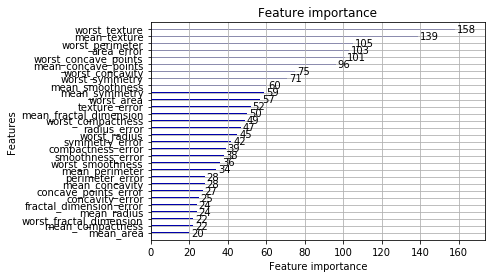

In [10]:
lgb.plot_importance(lgbm)

モデルのメソッド***feature_importances()***を用いても描画できる。  
* こっちのほうが格好良く描画可能。

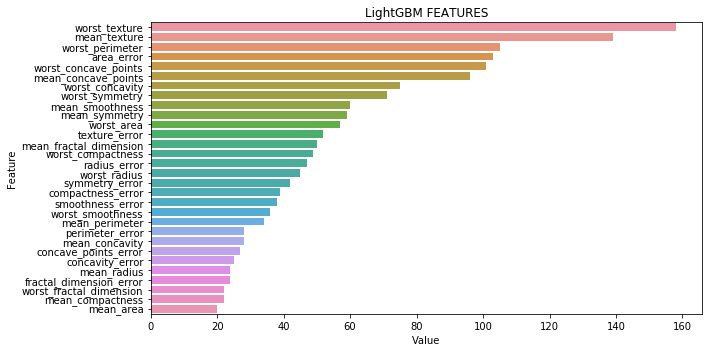

In [11]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), lgbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

<br>

#### Ex1-2-3. LightGBMのパラメータ調整

それではlight-gbmのパラメータを調整し、スコア向上を目指す。  

パラメータ調整には、手動でやる方法と最適化アルゴリズムを用いる方法がある。  
最適化は後の勉強会で扱うので、ここでは手動でやってみる。

<br>

パラメータ調整の方法は、公式ガイドを参照。  
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

あるいは、light-gbmの日本人コントリビューターである「大元 司」氏の資料を参照。  
https://alphaimpact.jp/downloads/pydata20190927.pdf

In [12]:
lgbm_params = {
    'objective': 'binary', # 二値分類問題
    'metric': 'auc', # 評価指標「AUC」の最大化を目指す
    'verbose': -1, # 学習中の情報を表示しない。表示したい場合は1を指定。
    
    'n_estimators': 10000, # 木の数。途中で学習を終了するearly_stopping(後記)を使うので、大きい数字がいい
    'num_leaves': 50, # 1つの木の葉の最大数。2～100くらい。
    'max_depth': 7, # 木の深さの最大値。7固定。
    #'min_data_in_leaf': 70, # 1つの葉の中のデータ最小個数。1～50
    'learning_rate': 0.1, # 学習率
    'random_state': 42 # 乱数シード
}

# 上記のパラメータでモデルを学習する
lgbm = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred_r = np.where(y_pred > 0.5, 1, 0)

print("light-gbm auc score: {:.3f}".format(auc))
print("light-gbm accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_r)))

light-gbm auc score: 0.999
light-gbm accuracy score: 0.979


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


<br>

わずかだが、パラメータ調整することで精度が向上した。

|調整前 |調整後|
|:-:    |:-:   |
|0.972  |0.979 |

今回の例ではあまり実感がないが、light-gbmはパラメータに敏感であり、性能が簡単に変わってしまう。  
実用上はパラーメータ最適化アルゴリズムの利用などが良いと思われる。

<br>

**early_stoppingとは**

上で少し触れたが、LightGBMには***early_stopping***と呼ばれる、  
学習を途中で打ち切る機能が実装されている。


勾配ブースティング決定木全般の欠点として過学習しやすいことは説明した。  
LightGBMも例外ではなく、学習を進めば進めるほど、訓練セットに特化したモデルとなる。

<br>

そこで、モデルの訓練時に「汎化性能が向上しなくなったら、そこで学習を打ち切る」という、  
***early_stopping_rounds***パラメータを指定する。


上の例では、***early_stopping_rounds=10***と指定したので、  
学習を進めていく途中で10回学習してもテスト精度が向上しなかったら、  
そこで学習を打ち切ってその時点で学習済モデルとして出力される、という挙動を示す。

<br>

#### Ex1-2-4. LightGBMのまとめ

LightGBMは勾配ブースティング決定木の1種であり、幅広く使われているアルゴリズム。  

データはスケーリングする必要もなく、また欠損値(NaN)などもそのまま入力できる。
かつ、性能も高いのでよく使われる。

特徴量の重要度も確認しやすく、その情報をもとに新たな特徴を作ることもできる。

<br>

欠点として、パラメータにシビアな点が挙げられる。  
対策としては、最適化アルゴリズムを用いることで、性能の良いパラメータを自動で探すことができる。
* 慣れてきて勘がついたら、手動でもいいかもしれない(狙いの性能が達成できれば)


<br>

---

#### Ex1-2-5. XGBoostの実装例(Option)

LightGBMの比較として、XGBoostも実装してみる。  
本項はオプションのため興味ある人だけでOK。

詳細は公式を参照。  
https://xgboost.readthedocs.io/en/latest/

In [13]:
# XGboost
import xgboost as xgb

In [14]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

In [15]:
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'eval_metric': 'auc', # 評価指標
    'seed': 42 # 乱数シード
}
xgbm = xgb.train(xgb_params,
                xgb_train,
                num_boost_round=100,  # 学習ラウンド数は適当
                )

In [16]:
# 検証用データが各クラスに分類される確率を計算する
y_pred_proba = xgbm.predict(xgb_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

print("XGBoost auc score: {:.3f}".format(auc))
print("XGboost accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))

XGBoost auc score: 0.999
XGboost accuracy score: 0.986


<br>

XGboostの方がよかった（　＾ω＾）・・・  
しかもデフォルトで。

|LightGBM調整前 |LightGBM調整後|XGBoost調整前|
|:-:            |:-:           |:-:          |
|0.972          |0.979         |0.986        |

<br>

特徴量の重要度もプロットする。  

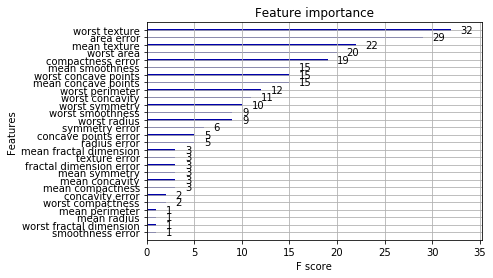

In [17]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(cancer.feature_names)}
mapped = {mapper[k]: v for k, v in xgbm.get_fscore().items()}
xgb.plot_importance(mapped)

別のやりかた。

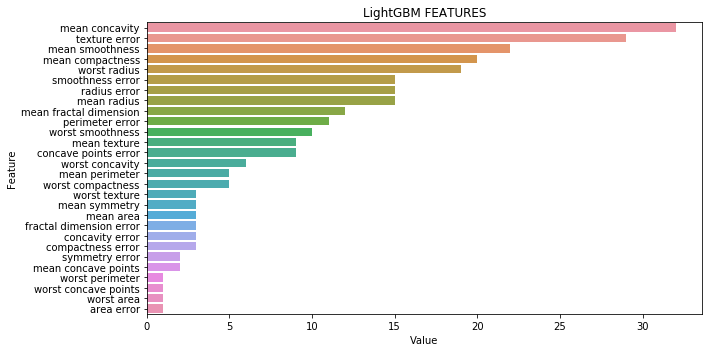

In [18]:
feature_imp = pd.DataFrame(sorted(zip(xgbm.get_fscore().values(), cancer.feature_names),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

<br>

パラメータ調整もやってみよう。  

公式    
https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [19]:
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'eval_metric': 'auc', # 評価指標
    'verbosity': 0, # 学習中の情報を表示しない。表示したい場合は1を指定。
    'seed': 42, # 乱数シード
    
     'eta': 0.1, # 学習率
     'max_depth': 6, # 木の深さ
     'min_child_weight': 5 #1つの葉の中のデータ最小個数5
}
evals = [(xgb_train, 'train'), (xgb_test, 'eval')]
evals_result = {}
xgbm = xgb.train(xgb_params,
                xgb_train,
                num_boost_round=10000,
                # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result,
                verbose_eval=False
                )

# 検証用データが各クラスに分類される確率を計算する
y_pred_proba = xgbm.predict(xgb_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

print("XGBoost auc score: {:.3f}".format(auc))
print("XGboost accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred)))

XGBoost auc score: 0.985
XGboost accuracy score: 0.972


<br>

|LightGBM調整前 |LightGBM調整後|XGBoost調整前|XGBoost調整後|
|:-:            |:-:           |:-:          |:-:          |
|0.972          |0.979         |0.986        |0.972        |

（　＾ω＾）・・・  
下手にパラメータいじるより、デフォルトで使うか最適化アルゴリズムを使おう。

<br>

---

#### Ex1-2-6. CatBoostの実装例(Option)

CatBoostも実装してみる。  
本項はオプションのため興味ある人だけでOK。

詳細は公式を参照。  
https://catboost.ai/docs/

In [20]:
# CatBoost
from catboost import CatBoost
from catboost import Pool

In [21]:
# CatBoost が扱うデータセットの形式に直す
cat_train = Pool(X_train, label=y_train)
cat_test = Pool(X_test, label=y_test)

In [22]:
# 学習用のパラメータ
params = {
    'loss_function': 'Logloss',# タスク設定と損失関数
    'eval_metric': 'AUC', # 評価指標
    'num_boost_round': 100,# 学習ラウンド数
}
    
catm = CatBoost(params)
catm.fit(cat_train,
        verbose_eval=False,
        )

In [23]:
y_pred = catm.predict(cat_test, prediction_type='Class')

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred_r = np.where(y_pred > 0.5, 1, 0)

print("XGBoost auc score: {:.3f}".format(auc))
print("XGboost accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_r)))

XGBoost auc score: 0.970
XGboost accuracy score: 0.972


<br>

|LightGBM調整前 |LightGBM調整後|XGBoost調整前|XGBoost調整後|CatBoost調整前|
|:-:            |:-:           |:-:          |:-:          |:-:           |
|0.972          |0.979         |0.986        |0.972        |0.972         |

あまり良くない。

<br>

特徴量の重要度もプロットする。  
Catboostもプロットメソッドはないらしいので、自前で作る。  

ここでは、matplotlibのラッパーである***seaborn***を使って描画する。

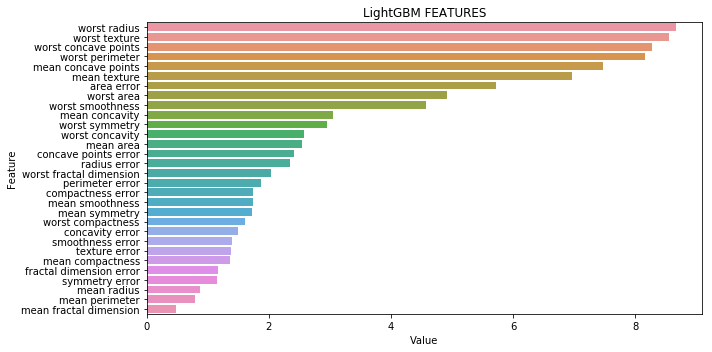

In [24]:
feature_imp = pd.DataFrame(sorted(zip(catm.get_feature_importance(), cancer.feature_names),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

<br>

パラメータ調整

In [25]:
# 学習用のパラメータ
params = {
    'loss_function': 'Logloss',# タスク設定と損失関数
    'eval_metric': 'AUC', # 評価指標
    'num_boost_round': 10000,# 学習ラウンド数
    
    'early_stopping_rounds': 10, # early_stopping
    'use_best_model': True, # 一番いいモデルを使う
    'od_type': 'IncToDec', # 過学習検知
    'od_pval': 0.01, # 過学習検知の閾値
    'learning_rate': 0.4, # 学習率
    'depth': 6, # 木の深さ
}
    
catm = CatBoost(params)
catm.fit(cat_train,
         eval_set=[cat_test],
        verbose_eval=False,
        )

y_pred = catm.predict(cat_test, prediction_type='Class')

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred_r = np.where(y_pred > 0.5, 1, 0)

print("XGBoost auc score: {:.3f}".format(auc))
print("XGboost accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_r)))

XGBoost auc score: 0.983
XGboost accuracy score: 0.979


<br>

|LightGBM調整前 |LightGBM調整後|XGBoost調整前|XGBoost調整後|CatBoost調整前|CatBoost調整後|
|:-:            |:-:           |:-:          |:-:          |:-:           |:-:          |
|0.972          |0.979         |0.986        |0.972        |0.972         |0.979        |

手動の調整は大変そうだ。  
やはり最適化アルゴリズムを使うのがよろしい。

<br>

---

#### Ex1-2-7. 比較のまとめ(Option)

冒頭ではLightGBMが良いと主張したが、比較実験ではXGBoostが一番性能が高かった。
* しかもデフォルトパラメータ

しかし、これはXGboostが一番優れている、という訳ではなく、  
パラメータによって容易く変わってしまうことを意味する。

<br>

あくまで2019年11月時点でおすすめなのはLightGBM(CatBoostでもいいかも)。  
ただし、パラメータ調整には時間がかかることは注意しておきたい。

<br>

---

## 演習

別資料で実施する。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。